<a href="https://colab.research.google.com/github/gmortuza/Google-Landmark-Recognition-2020/blob/master/model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Copy dataset & Importing module & defining constant
---



In [1]:
# Moving dataset from google drive to colab sessions
# The kaggle dataset is huge(~100GB). Copying that amount of data in every session is not feasible. 
# So created a sample data set. 
# Which I updloaded into the drive
from google.colab import drive
drive.mount("/content/drive")
!mkdir data
!mkdir data/train
!cp "/content/drive/My Drive/kaggle_competition/Google_Landmark_Recognition_2020/data.zip" /content/data/train
!unzip /content/data/train/data.zip

Streaming output truncated to the last 5000 lines.
  inflating: data_1/train/2/6/8/268081581de3d190.jpg  
  inflating: data_1/train/2/6/8/268d99b62dab8ea0.jpg  
  inflating: data_1/train/2/6/8/268a9be22427e041.jpg  
  inflating: data_1/train/2/6/8/268952eb35daa053.jpg  
  inflating: data_1/train/2/6/8/26804f423e56e247.jpg  
  inflating: data_1/train/2/6/8/2687c4b647691649.jpg  
  inflating: data_1/train/2/6/8/268fc97eeb8ac6d2.jpg  
  inflating: data_1/train/2/6/8/268949ae6c0d3975.jpg  
  inflating: data_1/train/2/6/a/26a4764b5ab181f4.jpg  
  inflating: data_1/train/2/6/a/26a87a8e15d12f02.jpg  
  inflating: data_1/train/2/6/a/26a38897822dde86.jpg  
  inflating: data_1/train/2/6/a/26af2f67d0d63863.jpg  
  inflating: data_1/train/2/6/a/26a2cab94eb6a6f3.jpg  
  inflating: data_1/train/2/6/a/26a24bbb339c4b45.jpg  
  inflating: data_1/train/2/6/a/26a1b06cc81a7eaa.jpg  
  inflating: data_1/train/2/6/a/26a23a92f129ca3f.jpg  
  inflating: data_1/train/2/6/a/26ab5f3ad4af6a17.jpg  
  inflating: d

In [42]:
#%%
# Importing necessary module
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import EarlyStopping
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import pandas as pd

In [54]:
#%%
# Define constant
BATCH_SIZE = 32
IMAGE_SIZE_WITHOUT_CHANNEL= (608, 736)
IMAGE_SIZE_WITH_CHANNEL = (608, 736, 3)
VALIDATION_RATE = 0.2
OUTPUT_CLASS = 73476
BATCH_SIZE = 32 
EPOCH = 10
LOG_DIR = os.path.join(os.getcwd(), 'logs')
CHECKPOINT = os.path.join(os.getcwd(),'checkpoint','model.h5')
DATA_DIR = 'data_1/'
TRAIN_DIR = os.path.join(DATA_DIR, 'train')
TEST_DIR = os.path.join(DATA_DIR, 'test')
TRAIN_FILE = os.path.join(TRAIN_DIR, 'train.csv')

# Loading training data

In [51]:
train_df = pd.read_csv(TRAIN_FILE)
train_df.landmark_id = train_df.landmark_id.astype(str)
train_df["location"] = os.getcwd() +"/"+ TRAIN_DIR + "/"+train_df.id.str[0]+"/"+train_df.id.str[1]+"/"+train_df.id.str[2]+"/"+train_df.id+".jpg"


#train_df = train_df.sample(10000, random_state=10)

In [52]:
train_df = train_df[:1000]

In [53]:
gen = ImageDataGenerator(rescale=1./255, validation_split=VALIDATION_RATE)
train_generator = gen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="location",
    y_col="landmark_id",
    target_size=IMAGE_SIZE_WITHOUT_CHANNEL,
    seed=42,
    shuffle=True,
    batch_size=BATCH_SIZE,
    subset="training",
    colormode="rgb"
)
validation_generator = gen.flow_from_dataframe(
    dataframe=train_df,
    directory=TRAIN_DIR,
    x_col="location",
    y_col="landmark_id",
    target_size=IMAGE_SIZE_WITHOUT_CHANNEL,
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    seed=42,
    shuffle=True,
    subset="validation",
    colormode="rgb"
)

Found 244 validated image filenames belonging to 40 classes.
Found 61 validated image filenames belonging to 40 classes.


/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 695 invalid image filename(s) in x_col="location". These filename(s) will be ignored.
  .format(n_invalid, x_col)


# Base model

In [24]:
def base_model():

  model = Sequential()
  model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=IMAGE_SIZE_WITH_CHANNEL))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
  model.add(MaxPool2D(pool_size=(2, 2)))
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(256, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(512, activation='relu'))
  model.add(Dropout(.3))
  model.add(Dense(40, activation='softmax'))
  return model

In [43]:
def get_callback(reduceLR=True, chkPoint=True, earlyStop=True, tensorBoard=True):
  callbacks = []
  if reduceLR:
    reduceLR = ReduceLROnPlateau(monitor = 'val_loss',
                                patience = 3,
                                factor = 0.5,
                                min_lr = 1e-2,
                                verbose = 1,)
    callbacks.append(reduceLR)
  if chkPoint:
    if not os.path.isdir(os.path.dirname(CHECKPOINT)):
      os.makedirs(os.path.dirname(CHECKPOINT))
    chkPoint = ModelCheckpoint(CHECKPOINT,
                              monitor = 'loss',
                              save_best_only = True,
                              save_weights_only = False,
                              mode = 'auto',
                              save_freq = 'epoch',
                              verbose = 1)
    callbacks.append(chkPoint)
  if earlyStop:
    earlyStop = EarlyStopping(monitor='val_loss',
                              mode = 'auto',
                              patience = 4,
                              min_delta = 0,
                              verbose = 1)
    callbacks.append(earlyStop)
  
  if tensorBoard:
    tensorBoard = TensorBoard(log_dir=LOG_DIR,
                              write_graph=True,
                              update_freq='epoch'
                              )
    callbacks.append(tensorBoard)
  
  return callbacks

In [48]:
def get_model(model_type='base'):
  if os.path.isfile(CHECKPOINT):
    print("A model already exists")
    model = tf.keras.models.load_model(CHECKPOINT)
    return model
  print("No check point model exists. Creating model now")
  if model_type=='base':
    model = base_model()
  
  # Compile the model 
  model.compile(optimizers.Adam(lr=0.001, decay=1e-6), loss="categorical_crossentropy", metrics=["accuracy"])
  return model

In [45]:
steps_per_epoch = 40 // BATCH_SIZE
steps_per_epoch

1

In [55]:
callback = get_callback()
model = get_model()
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, verbose=1, callbacks=callback)

A model already exists
Epoch 1/10
1/8 [==>...........................] - ETA: 0s - loss: 1.7418 - accuracy: 0.5312WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
8/8 [==============================] - ETA: 0s - loss: 1.8727 - accuracy: 0.5574
Epoch 00001: loss improved from inf to 1.87273, saving model to /content/checkpoint/model.h5
8/8 [==============================] - 5s 613ms/step - loss: 1.8727 - accuracy: 0.5574 - val_loss: 5.1958 - val_accuracy: 0.3770
Epoch 2/10
8/8 [==============================] - ETA: 0s - loss: 1.8395 - accuracy: 0.5697
Epoch 00002: loss improved from 1.87273 to 1.83946, saving model to /content/checkpoint/model.h5
8/8 [==============================] - 4s 540ms/step - loss: 1.8395 - accuracy: 0.5697 - val_loss: 7.0095 - val_accu

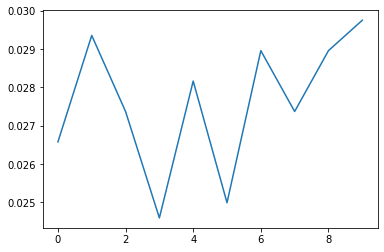

In [21]:
plt.plot(history.history['accuracy'])

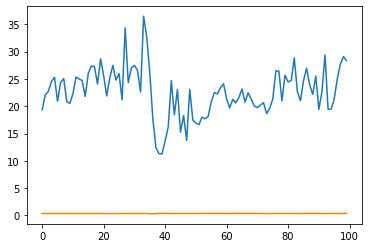

In [ ]:
plt.plot(history.history['val_loss'])
plt.plot(history.history['val_accuracy'])

In [63]:
!tensorboard --logdir=LOG_DIR


2020-09-19 01:48:45.013927: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 5, in <module>
    from tensorboard.main import run_main
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 43, in <module>
    from tensorboard import default
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/default.py", line 40, in <module>
    from tensorboard.plugins.beholder import beholder_plugin_loader
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/plugins/beholder/__init__.py", line 18, in <module>
    import tensorflow
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/__init__.py", line 41, in <module>
    from tensorflow.python.tools import module_util as _module_util
  File "/usr/local/lib/python3.6/dist-packages/tensorflow/python/__init__.py", line 46, in <module>
    from tensorflow.python import distr

In [64]:
!pip install tensorboardcolab

In [ ]:
!zip LOG_DIR 